<a href="https://colab.research.google.com/github/fernandoGitHub/ML_Use_Cases/blob/main/Soccer_Ball_Recognition_and_Verification/Soccer_Ball_Recognition_and_Verification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a name='A'></a>
# Soccer Ball Recognition and Verification

The other day a customer came to me with a very accute problem. He is managing a famous Auctions firm specializing in the sale of sport antiquities. He explained that he is losing lots of money due to mistakes made on the recognition of the items they are selling.
According to him, the worse case was related to the World-Cup Official Soccer Balls.

When I asked, why don't they print a picture catalog, he responded that his personal gets very confused due to the relative rotation of the balls, different angles, obstructions, and the huge number of items.

I happily informed him that he is in the right place and Neural Networks are here to help. I offered him to apply existing face recognition systems to his problem and he agreed to fund this project.



I used the following papers as referece: [FaceNet](https://arxiv.org/pdf/1503.03832.pdf) and [DeepFace](https://research.fb.com/wp-content/uploads/2016/11/deepface-closing-the-gap-to-human-level-performance-in-face-verification.pdf).

This solution has two valid use-cases: 

1.   **Soccer Ball Verification** - "Is this the soccer ball it is claiming to be? This is a 1:1 matching problem.
2.   **Soccer Ball Recognition** - "What is exactly this soccer ball" This is a 1:K matching problem.

FaceNet is a neural network that encodes an image into a vector of 128 numbers. By comparing two such vectors, you can then determine if two pictures belong to the same soccer ball.

<a name='1'></a>
## 1 - Install Packages, Import Libraries & Setup

Go ahead and run the cell below to import the packages you'll need.

In [1]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
K.set_image_data_format('channels_last')

import os
import numpy as np
import pandas as pd
from numpy import genfromtxt
import pandas as pd

import PIL
import shutil
from zipfile import ZipFile

%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

In [11]:
!pip install --index-url https://test.pypi.org/simple/ --no-deps tools_fernandoGitHub --upgrade

Looking in indexes: https://test.pypi.org/simple/, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: tools-fernandoGitHub
    Found existing installation: tools-fernandogithub 0.0.12
    Uninstalling tools-fernandogithub-0.0.12:
      Successfully uninstalled tools-fernandogithub-0.0.12


In [12]:
from tools_fernandogithub import ff_setup as ffs
from tools_fernandogithub import ff_data_transfer as ffdt

In [13]:
[wget, ipdb, gdown, tqdm] = ffs.install_import_packages(['wget', 'ipdb', 'gdown', 'tqdm'])

Package: wget is already installed. Skipping installation
Reloading Packages
Package: ipdb is already installed. Skipping installation
Reloading Packages
Package: gdown is already installed. Skipping installation
Reloading Packages
Package: tqdm is already installed. Skipping installation
Reloading Packages


In [15]:
ffdt.clean_directory('.')

data_instructions=list()
data_instructions.append(('.', 'models.zip', 'https://github.com/fernandoGitHub/ML_Use_Cases/raw/main/Soccer_Ball_Recognition_and_Verification/data/', 'Github', False))
data_instructions.append(('./models', 'keras-facenet_tf23.zip', '1TN3xJrE60Vfyi-DGmKT9RgB3FVAysYgi', 'GDrive', False))
data_instructions.append(('./models', 'keras-facenet-h5.zip', '1TTj3O3l_QHEjweQKdMdYSxYqK2W_vURD', 'GDrive', False))
data_instructions.append(('./images', None, None, None, True))
data_instructions.append(('.', 'Soccer_Balls.zip', 'https://github.com/fernandoGitHub/ML_Use_Cases/raw/main/Soccer_Ball_Recognition_and_Verification/data/', 'Github', False))
ffdt.retrieve_data(data_instructions)

Cleaned directory: .
Fetching from GitHub: models.zip ...
Extracting files in models.zip ...
Fetching from Google Drive: keras-facenet_tf23.zip ...
Extracting files in keras-facenet_tf23.zip ...
Fetching from Google Drive: keras-facenet-h5.zip ...
Extracting files in keras-facenet-h5.zip ...
Creating directory: ./images ...
Fetching from GitHub: Soccer_Balls.zip ...
Extracting files in Soccer_Balls.zip ...


<a name='2'></a>
## 2 - Naive Soccer Ball Verification

In Soccer Ball Verification, we have to determine if two images belong to the same ball. The naive method would compare the two images pixel-by-pixel. If the distance between the raw images is below a chosen threshold, it may be the same ball!
But obviously this algorithm will perform poorly. Changes in the ball size, and rotation will increase the distance between the images and the algorithm will perform very bad.
<figure>
<img src="https://github.com/fernandoGitHub/ML_Use_Cases/raw/main/Soccer_Ball_Recognition_and_Verification/notebook_images/Naive_Comparison.jpg"style="width:750px;height:300px;">
</figure>

<a name='3'></a>
## 3 - Encoding Soccer Ball Images into a 128-Dimensional Vector

The FaceNet model we chose as being already trained... on human faces!!! (https://arxiv.org/abs/1409.4842) but we claimed it can be easily applied to soccer balls as well.
This will provide a rapid and cheap solution for our customer :-)

Some features of the chosen model:

- Input: 160x160 RGB images. We want the model to be fast and light.S
- Output: Matrix of shape (m, 128) where m is the number of examples

In [16]:
# Loading the pre-trained model
from tensorflow.keras.models import model_from_json

json_file = open('./models/keras-facenet-h5/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights('./models/keras-facenet-h5/model.h5')

In [17]:
model.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv2d_1a_3x3 (Conv2D)         (None, 79, 79, 32)   864         ['input_1[0][0]']                
                                                                                                  
 Conv2d_1a_3x3_BatchNorm (Batch  (None, 79, 79, 32)  96          ['Conv2d_1a_3x3[0][0]']          
 Normalization)                                                                                   
                                                                                

By using a 128-neuron fully connected layer as its last layer, the model ensures that the output is an encoding vector of size 128. You then use the encodings to compare two images as follows:
<figure>
<img src="https://github.com/fernandoGitHub/ML_Use_Cases/raw/main/Soccer_Ball_Recognition_and_Verification/notebook_images/distance.png"style="width:1000px;height:250px;">
</figure>

The triplet loss function formalizes this, and tries to "push" the encodings of two images of the soccer ball (Anchor and Positive) closer together, while "pulling" the encodings of two images of different soccer balls (Anchor, Negative) further apart.

<figure>
<img src="https://github.com/fernandoGitHub/ML_Use_Cases/raw/main/Soccer_Ball_Recognition_and_Verification/notebook_images/triplet_comparison.png"style="width:600px;height:300px;">
</figure>


<a name='4'></a>
## 4 - The Triplet Loss Function

Training will use triplets of images $(A, P, N)$:

- A is an "Anchor" image--a picture of a person.
- P is a "Positive" image--a picture of the same person as the Anchor image.
- N is a "Negative" image--a picture of a different person than the Anchor image.

These triplets are picked from the training dataset. $(A^{(i)}, P^{(i)}, N^{(i)})$ is used here to denote the $i$-th training example.

You'd like to make sure that an image $A^{(i)}$ of an individual is closer to the Positive $P^{(i)}$ than to the Negative image $N^{(i)}$) by at least a margin $\alpha$:

$$
|| f\left(A^{(i)}\right)-f\left(P^{(i)}\right)||_{2}^{2}+\alpha<|| f\left(A^{(i)}\right)-f\left(N^{(i)}\right)||_{2}^{2}
$$


You would thus like to minimize the following "triplet cost":

$$\mathcal{J} = \sum^{m}_{i=1} \large[ \small \underbrace{\mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2}_\text{(1)} - \underbrace{\mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2}_\text{(2)} + \alpha \large ] \small_+ \tag{3}$$
Here, the notation "$[z]_+$" is used to denote $max(z,0)$.

**Notes**:

- The term (1) is the squared distance between the anchor "A" and the positive "P" for a given triplet; you want this to be small.
- The term (2) is the squared distance between the anchor "A" and the negative "N" for a given triplet, you want this to be relatively large. It has a minus sign preceding it because minimizing the negative of the term is the same as maximizing that term.
- $\alpha$ is called the margin. It's a hyperparameter that you pick manually. You'll use $\alpha = 0.2$.

Most implementations also rescale the encoding vectors to haven L2 norm equal to one (i.e., $\mid \mid f(img)\mid \mid_2$=1).




In [18]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss as defined by formula (3)
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 128)
            positive -- the encodings for the positive images, of shape (None, 128)
            negative -- the encodings for the negative images, of shape (None, 128)
    
    Returns:
    loss -- real number, value of the loss
    """
    
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]

    # Step 1: Computing the (encoding) distance between the anchor and the positive
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis=-1)

    # Step 2: Computing the (encoding) distance between the anchor and the negative
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis=-1)

    # Step 3: subtracting the two previous distances and add alpha.
    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)

    # Step 4: Taking the maximum of basic_loss and 0.0. Sum over the training examples.
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0.0))
    
    return loss

<a name='5'></a>
## 5 - Loading the Pre-trained Model

FaceNet is trained by minimizing the triplet loss. But since training requires a lot of data and a lot of computation, you won't train it from scratch here. Instead, you'll load a previously trained model in the following cell; which might take a couple of minutes to run.

In [19]:
FRmodel = model

<a name='A.7'></a>
## 6 - Applying the Model





<a name='6.1'></a>
### 6.1 - Face Verification

In [20]:
def img_to_encoding(image_path, model):
  img = tf.keras.preprocessing.image.load_img(image_path, target_size=(160, 160))
  img = np.around(np.array(img) / 255.0, decimals=12)
  x_train = np.expand_dims(img, axis=0)
  embedding = model.predict_on_batch(x_train)
  return embedding / np.linalg.norm(embedding, ord=2)

In [21]:
def verify(image_path, identity, database, model):
  """
  Function that verifies if the soccer ball on the "image_path" image is equal to claimed "identity".
  
  Arguments:
    image_path -- path to an image
    identity -- string, type of a soccer ball you want to verfy
    database -- python dictionary mapping names of known soccer ball names (strings) to their encodings (vectors).
    model -- your Inception model instance in Keras

  Returns:
    dist -- distance between the image_path and the image of "identity" in the database.
    door_open -- True, if the door should open. False otherwise.
  """
  encoding = img_to_encoding(image_path, model)
  dist = np.linalg.norm(encoding-database[identity], ord=2)

  if dist < 0.7:
      print("It's " + str(identity) + ", now try to sell it or buy it accordingly!")
      door_open = True
  else:
      print("It's not " + str(identity) + ", try to find another fool!")
      door_open = False
    
  return dist, door_open

<a name='6.2'></a>
### 6.2 - Soccer Ball Verification

In [22]:
def who_is_it(image_path, database, model):
  """
  Implements face recognition for the office by finding who is the person on the image_path image.
  
  Arguments:
    image_path -- path to an image
    database -- database containing image encodings along with the name of the person on the image
    model -- your Inception model instance in Keras
  
  Returns:
    min_dist -- the minimum distance between image_path encoding and the encodings from the database
    identity -- string, the name prediction for the person on image_path
  """
  encoding =  img_to_encoding(image_path, model)
  min_dist = 100
  
  # Loop over the database dictionary's names and encodings.
  for (name, db_enc) in database.items():
    dist = np.linalg.norm(encoding-db_enc, ord=2)
    if dist < min_dist:
      min_dist = dist
      identity = name

  if min_dist > 0.7:
    print("Not in the database.")
  else:
    print ("it's " + str(identity) + ", the distance is " + str(min_dist))
      
  return min_dist, identity

### 6.3 - Use Case 1 - Soccer Ball recognition

Let's see how this architecture works for soccer balls! For this we grabbed pictures from FIFA's World Champeonship from 1930 till today. Let's create a new dataset and see how well it performs :-)

In [23]:
_BALLS_DIR = './Soccer Balls'

files = os.listdir(_BALLS_DIR)

data = list()
for file in files:
  full_path = os.path.join(_BALLS_DIR, file)
  year = file[0:4]
  model = file[5:-4]
  encoding = img_to_encoding(full_path, FRmodel)
  data.append((year, model, file, full_path, encoding))


balls_df = pd.DataFrame(data=data, columns=['Year', 'Model', 'File Name', 'Full Path', '128-Encoding'])

In [24]:
balls_df

,Year,Model,File Name,Full Path,128-Encoding
0,2014,Brazuca,2014-Brazuca.png,./Soccer Balls/2014-Brazuca.png,"[[-0.09069565, -0.04361246, 0.056054145, -0.10..."
1,1998,Ticolore,1998-Ticolore.png,./Soccer Balls/1998-Ticolore.png,"[[-0.044506587, -0.105916, 0.008054997, -0.097..."
2,1986,Azteca,1986-Azteca.png,./Soccer Balls/1986-Azteca.png,"[[0.0038236915, -0.07988425, -0.0023114262, -0..."
3,1962,Crack Top Star,1962-Crack Top Star.png,./Soccer Balls/1962-Crack Top Star.png,"[[0.023105264, -0.052546684, -0.083282076, -0...."
4,2010,Jobulani,2010-Jobulani.png,./Soccer Balls/2010-Jobulani.png,"[[-0.038832355, -0.10838953, -0.124639645, -0...."
5,2018,Nike Ordem 4,2018-Nike Ordem 4.png,./Soccer Balls/2018-Nike Ordem 4.png,"[[-0.04635075, -0.048670396, -0.011072473, -0...."
6,2006,Teamgeist,2006-Teamgeist.png,./Soccer Balls/2006-Teamgeist.png,"[[-0.07000536, -0.0837162, -0.014266172, -0.03..."
7,1994,Questra,1994-Questra.png,./Soccer Balls/1994-Questra.png,"[[-0.07018694, -0.09978842, 0.020904118, -0.10..."
8,1966,Challenge 4-star,1966-Challenge 4-star.png,./Soccer Balls/1966-Challenge 4-star.png,"[[0.034518003, -0.05053023, 0.02699125, -0.129..."
9,1934,Federale 102,1934-Federale 102.png,./Soccer Balls/1934-Federale 102.png,"[[-0.05307719, -0.05854627, -0.1118081, -0.110..."


Notice the encoding is the 5th column.

Now, let's redefine the adfs function to work nicely on dataframes (I just love them)

In [25]:
def what_ball_is_it(encoding, balls_df):
  """
  Implements BALL RECOGNITION to tell you what World Cup is being played.
  
  Arguments:
      encoding
      ball_df
  
  Returns:
      min_dist -- the minimum distance between image_path encoding and the encodings from the database
      identity -- string, the name prediction for the person on image_path
  """
  N_balls = balls_df.shape[0]

  res = [0] * N_balls
  for i in range(N_balls):
     res[i] = np.linalg.norm(balls_df['128-Encoding'][i] - encoding, ord=2)
  balls_df['L2 Distance'] = res                  

  cand_id = balls_df['L2 Distance'].idxmin()
      
  return cand_id

Selected ball - 	Model: Tango Durlast - Year: 1978


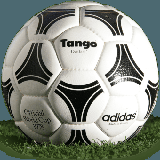

Recognized ball - 	Model: Tango Durlast - Year: 1978


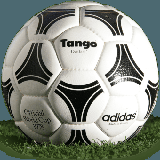




Selected ball - 	Model: Federale 102 - Year: 1934


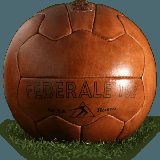

Recognized ball - 	Model: Federale 102 - Year: 1934


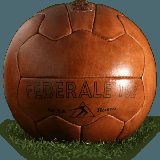




Selected ball - 	Model: Azteca - Year: 1986


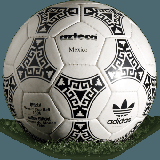

Recognized ball - 	Model: Azteca - Year: 1986


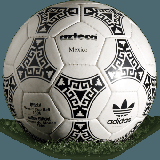




Selected ball - 	Model: Telstar - Year: 1970


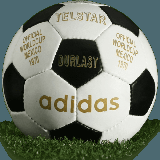

Recognized ball - 	Model: Telstar - Year: 1970


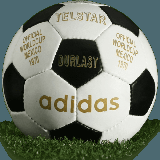




Selected ball - 	Model: Telstar - Year: 1970


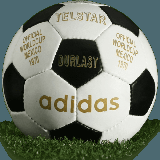

Recognized ball - 	Model: Telstar - Year: 1970


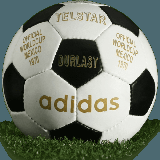

In [26]:
# Testing the recognition capabilities on World-Cup Soccer Balls
for i in range(5):
  sel = np.random.randint(0, balls_df.shape[0])
  print(f"Selected ball - \tModel: {balls_df['Model'][sel]} - Year: {balls_df['Year'][sel]}")
  sel_image = tf.keras.preprocessing.image.load_img(balls_df['Full Path'][sel], target_size=(160, 160))
  display(sel_image)

  encoding = img_to_encoding(balls_df['Full Path'][sel], FRmodel)
  rec = what_ball_is_it(encoding, balls_df)
  print(f"Recognized ball - \tModel: {balls_df['Model'][rec]} - Year: {balls_df['Year'][rec]}")
  rec_image = tf.keras.preprocessing.image.load_img(balls_df['Full Path'][rec], target_size=(160, 160))
  display(rec_image)
  print('\n\n')

Well, now we can really agree we implemented an useful solution for a valuable and usable application. But wait... what if the balls are rotated? Let's give it a try.

Selected ball - 	Model: Allen - Year: 1938 - Rotation = 10 degrees


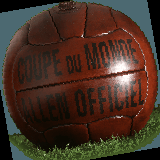

Recognized ball - 	Model: Allen - Year: 1938


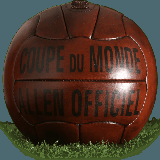




Selected ball - 	Model: Brazuca - Year: 2014 - Rotation = 272 degrees


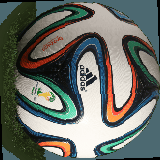

Recognized ball - 	Model: Brazuca - Year: 2014


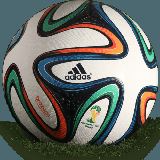




Selected ball - 	Model: Ticolore - Year: 1998 - Rotation = 90 degrees


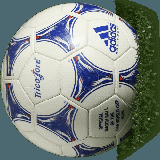

Recognized ball - 	Model: Ticolore - Year: 1998


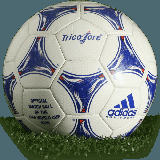




Selected ball - 	Model: T-Model - Year: 1930 - Rotation = 59 degrees


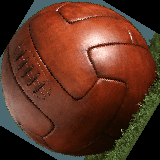

Recognized ball - 	Model: T-Model - Year: 1930


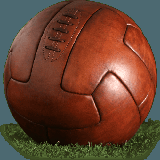




Selected ball - 	Model: Brazuca Final Rio - Year: 2014 - Rotation = 135 degrees


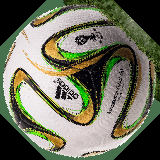

Recognized ball - 	Model: Brazuca Final Rio - Year: 2014


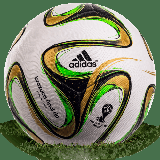

In [27]:
# Testing the recognition capabilities on World-Cup Soccer Balls
for i in range(5):
  sel = np.random.randint(0, balls_df.shape[0])
  rotation = np.random.randint(10, 350)
  print(f"Selected ball - \tModel: {balls_df['Model'][sel]} - Year: {balls_df['Year'][sel]} - Rotation = {rotation} degrees")
  sel_image = tf.keras.preprocessing.image.load_img(balls_df['Full Path'][sel], target_size=(160, 160))
  sel_image = sel_image.rotate(rotation, PIL.Image.NEAREST)
  display(sel_image)

  encoding = img_to_encoding(balls_df['Full Path'][sel], FRmodel)
  rec = what_ball_is_it(encoding, balls_df)
  print(f"Recognized ball - \tModel: {balls_df['Model'][rec]} - Year: {balls_df['Year'][rec]}")
  rec_image = tf.keras.preprocessing.image.load_img(balls_df['Full Path'][rec], target_size=(160, 160))
  display(rec_image)
  print('\n\n')

Now... we really really impressed :-)

Another good useful solution deployed to a happy satisfied customer! 

Time to play some soccer and move to the next one...

<a name='7'></a>
## 7 - References
1. Florian Schroff, Dmitry Kalenichenko, James Philbin (2015). [FaceNet: A Unified Embedding for Face Recognition and Clustering](https://arxiv.org/pdf/1503.03832.pdf)

2. Yaniv Taigman, Ming Yang, Marc'Aurelio Ranzato, Lior Wolf (2014). [DeepFace: Closing the gap to human-level performance in face verification](https://research.fb.com/wp-content/uploads/2016/11/deepface-closing-the-gap-to-human-level-performance-in-face-verification.pdf)

3. This implementation also took a lot of inspiration from the official FaceNet github repository: https://github.com/davidsandberg/facenet

4. Further inspiration was found here: https://machinelearningmastery.com/how-to-develop-a-face-recognition-system-using-facenet-in-keras-and-an-svm-classifier/

5. And here: https://github.com/nyoki-mtl/keras-facenet/blob/master/notebook/tf_to_keras.ipynb